# Decision trees in sklearn

Sklearn in 3 bullets:
1. A very popular python ML library, contains almost every algorithm family
2. Has numerous utility features to assist on all steps of the analysis pipeline
3. Optimized for prototyping (covering some production-oriented libraries tomorrow)

### Load the data

In [1]:
import numpy as np
data = np.load('data.npz')
X, y = data["X"], data["y"]
print(X.shape, y.shape)

((4505, 2), (4505,))


### Create train/test split

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.5, random_state=1337)

### Plot the full dataset

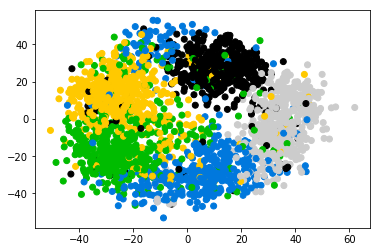

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap='nipy_spectral');

# Train a decision tree

Scikit-learn Decision Tree classifier has a few notable parameters

* criterion : 'gini' or 'entropy', used to select best split (default gini).
* max_depth :  The maximum depth of the tree. (default unlimited).
* min_samples_split : The minimum number of samples required to split an internal node (default 2).
* min_samples_leaf : The minimum number of samples required to be at a leaf node (default 1).

For now, all of them are at their default values, but we shall need them soon.

In [36]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=5,max_leaf_nodes=10)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

One of the few advantages of the decision tree is its interpretability

### Display decision boundaries

In [6]:
from sklearn.metrics import accuracy_score
def plot_decision_surface(clf, X, y,
                          plot_step = 0.2,
                          cmap='nipy_spectral',
                          figsize=(12,8)
                         ):
    """
    For a sklearn-compartiable classifier plots the decision surface along with some
    points.
    Args:
       clf - a sklearn-compartiable classifier
       X - features array, shape=(n_objects, n_features)
       y - labels array, shape=(n_objcts)
       plot_strp - decision surface grid step
       cmap - color map
       figsize - figure size"""
    fig, ax = plt.subplots(figsize=figsize)
    n_classes = len(clf.classes_)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap,alpha=0.5)    
    y_pred = clf.predict(X)

    ax.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='.',cmap=cmap,alpha=0.5,label='correct')
    ax.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #plt.axis("tight")
    ax.legend(loc='best')
    print("Accuracy = %f" % accuracy_score(y, y_pred))

### Training performance

Accuracy = 1.000000


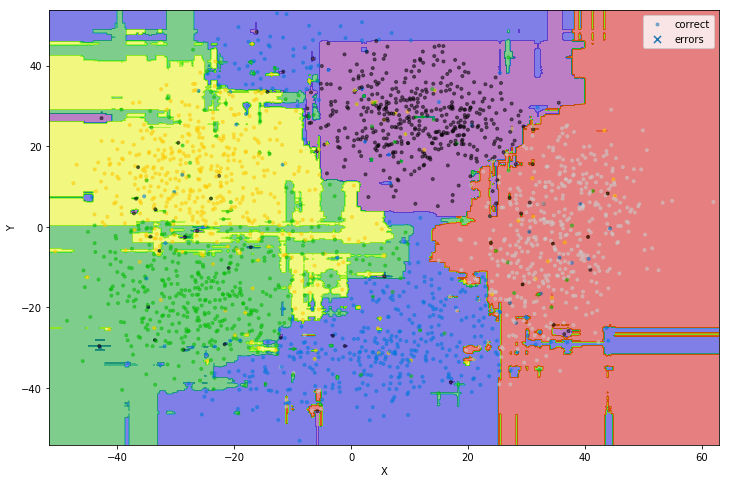

In [52]:
plot_decision_surface(tree, X_train, Y_train);

### Validation performance

In [ ]:
plot_decision_surface(tree, X_test, Y_test);

Now go back and __tune the tree__!

In [40]:
forest = []
for i in range(1000):
    X_s,_,Y_s,_ = train_test_split(X_train, Y_train, train_size=0.9)
    forest.append(
        DecisionTreeClassifier()
    )
    forest[-1].fit(X_s, Y_s)

In [46]:
def forest_predict():
    preds = []
    for tree in forest:
        preds.append(tree.predict_proba(X_test))
    print(np.mean(preds, axis=0).argmax(axis=-1))

In [47]:
forest_predict()

[0 2 0 ..., 3 4 2]


In [54]:
from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
tree.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

# Linear models

In [9]:
from sklearn.linear_model import LogisticRegression

Accuracy = 0.775854


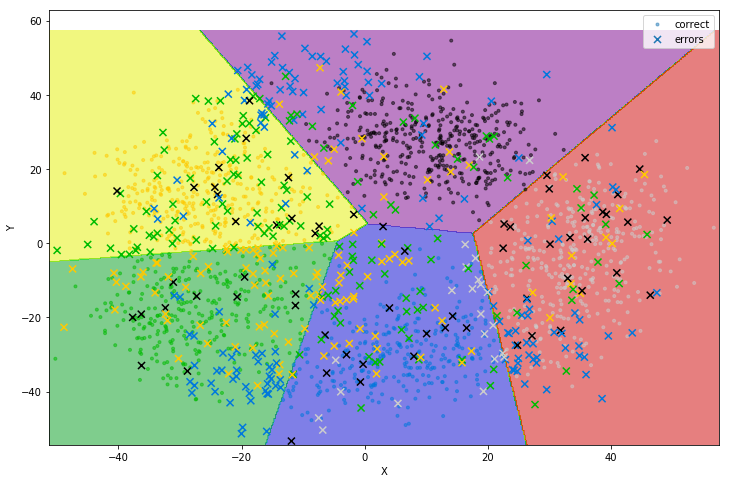

In [10]:
plot_decision_surface(LogisticRegression(C=1.).fit(X_train, Y_train), X_test, Y_test)

Accuracy = 0.758988


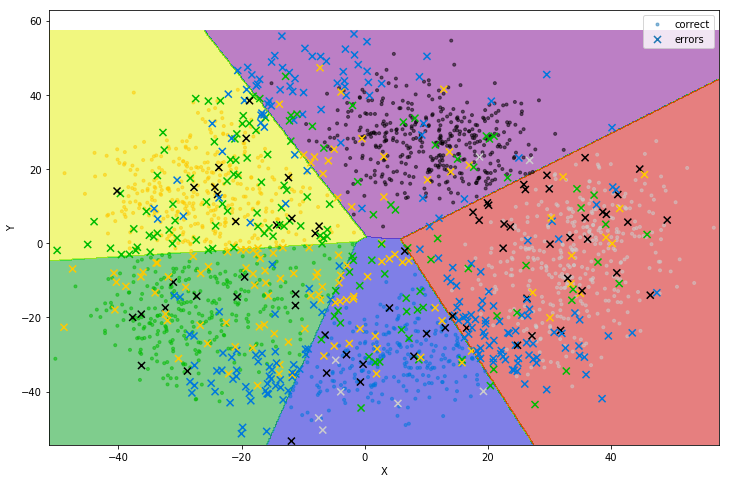

In [11]:
plot_decision_surface(LogisticRegression(C=1e-2).fit(X_train, Y_train), X_test, Y_test)

Accuracy = 0.777186


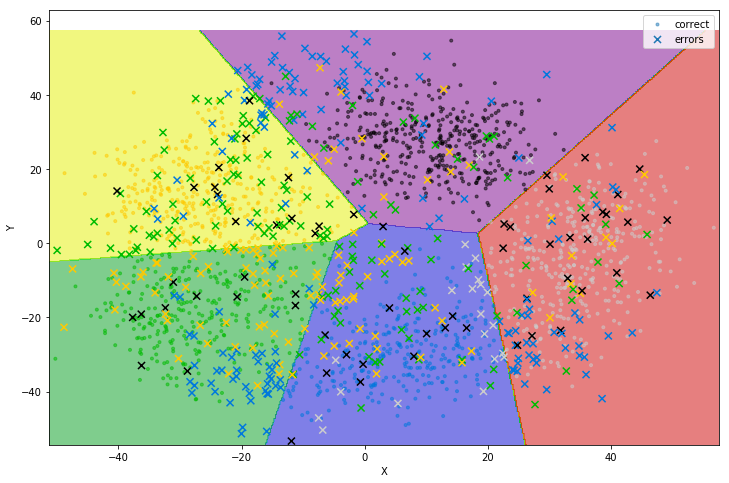

In [12]:
plot_decision_surface(LogisticRegression(C=1e3).fit(X_train, Y_train), X_test, Y_test)

Bagging ensembles

In [13]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

Accuracy = 0.770084


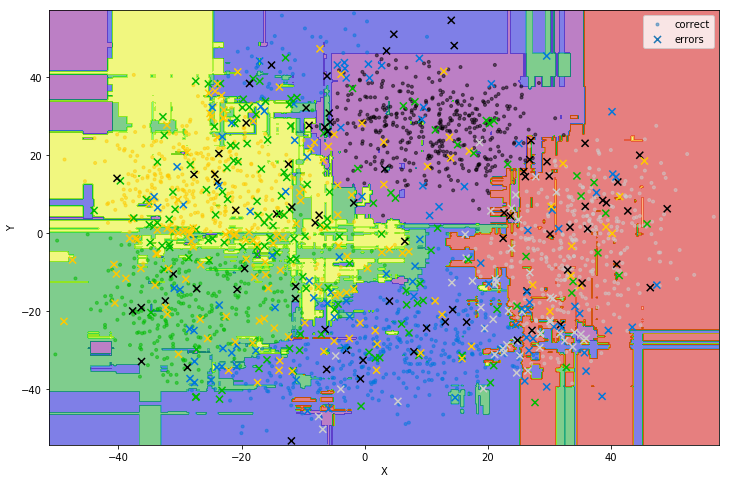

In [14]:
plot_decision_surface(RandomForestClassifier(n_jobs=-1).fit(X_train, Y_train), X_test, Y_test)

# Quality metrics
Too many of them, select according to your task. For binary classification the most common is ROC AUC.

In [15]:
Y_train_binary = (Y_train > 0)
Y_test_binary = (Y_test > 0)
binary_tree = DecisionTreeClassifier().fit(X_train, Y_train_binary)

In [16]:
import sklearn.metrics

In [17]:
# Pay attention we use predict_proba(), not the simple predict()
# Also pay attention that predict_proba return shape in (n_obejcts, n_classes)
sklearn.metrics.roc_auc_score(Y_test_binary, binary_tree.predict_proba(X_test)[:, 1])

0.86141025671816718

In [18]:
sklearn.metrics.accuracy_score(Y_test_binary, binary_tree.predict_proba(X_test)[:, 1])

0.91478029294274299

In [19]:
# Will fail
# sklearn.metrics.accuracy_score(Y_test, tree.predict_proba(X_test))

In [20]:
sklearn.metrics.accuracy_score(Y_test, tree.predict(X_test))

0.70705725699067912

# Cross-validation

In [21]:
from sklearn.model_selection import cross_val_score

In [ ]:
# Will fail
# cross_val_score(DecisionTreeClassifier(), X, y, scoring="roc_auc")

In [22]:
cross_val_score(DecisionTreeClassifier(), X, y, scoring="accuracy", n_jobs=-1, cv=10)

array([ 0.67920354,  0.71460177,  0.71175166,  0.7383592 ,  0.71175166,
        0.71396896,  0.68957871,  0.72666667,  0.71428571,  0.69419643])

# Bonus Exercises
## One
The tree has clearly overfitted - train performance is much better than test. Plot train accuracy and test accuracy as a function of maximum tree depth

In [ ]:
# <your code goes here>

## Two
The result is still too bad for MLHEP! Your quest is to fix this issue by tweaking decision tree hyperparameters using the cross-validation score as the guide. A few most helpful ones are provided above the DecisionTreeClassifier definition.
 * Accuracy >= 0.72 is a start, but you can do better
 * Accuracy >= 0.75 is better, but still improvable
 * Accuracy >= 0.78 is a reasonably good result
 * Accuracy >= 0.8 is either epic skill or luck. Be sure to tell us if you got it!

In [ ]:
# <your code goes here>

## Three
Use the best parameters you found for a single tree in a RandomForest classifier. Plot it's cross-validation performance as the number of trees used. Plot the untuned RandomForest performance as the function of the number of trees used.

In [ ]:
# <your code goes here>

## Four
How good is your numpy and Python? Can you implement a sklearn-compartiable linear regression class? Need methods:
```
fit(X, y)
Args:
X: a numpy array shape=(n_objects, n_features)
y: a numpy array shape=(n_objects)

Returns self

predict(X)
Args:
X: a numpy array shape=(n_objects, n_features)

Returns a numpy array shape=(n_objects)
```
Compare its performance to the Ridge regression from sklearn. Bonus points for regularization support.

In [ ]:
import sklearn.datasets

In [ ]:
x_linear, y_linear = sklearn.datasets.make_regression(
        n_samples=int(1e4), n_features=5, n_informative=4, random_state=42, noise=5)

In [ ]:
x_linear_train, x_linear_test, y_linear_train, y_linear_test = train_test_split(x_linear, y_linear, train_size=50,
                                                                                random_state=124)

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
sklearn.metrics.mean_squared_error(y_linear_test,
                                   Ridge().fit(x_linear_train, y_linear_train).predict(x_linear_test))

In [ ]:
# <your code goes here>

## Five
Why does BaggingClassifier not improve the linear regression quality?

In [ ]:
plot_decision_surface(BaggingClassifier(
    base_estimator=LogisticRegression(C=1e3), n_jobs=-1).fit(X_train, Y_train), X_test, Y_test)